# Does Your Kickstarter Suck?
Analysis of kickstarter data to predict success of campaign

## Goals
Crowdsourcing is an increasingly popular way for entreuprenuers to raise money for a product, project or somethig. Kickstarter has emereged as the top funding platform for this purpose. I was interested in what makes a kickstarter campaign successful, specifically, what attributes are common in the most successful campaigns. The attibutes I wanted to look at in the campaigns were the main category, sub category, the funding goal, whether or not it was selected as a "staff pick," and the contents of the description of the product. 

## Data Wrangling and Cleaning
I obtained my data from webrobots.io, where they posted archived kickstarter data they have been scraping from the kickstarter website since 2015. There was over 40 gb of csv files archived on the site. The csv files contained json in serveral columns, as well as regularly typed data. I had to pull out relvant information from the json, as well as delete columns I determined didn't provide insight into the analysis. I also decided to work only on projects from the US, which would make the analysis easier for comparison against one another. 



# Model Fitting

## Numeric Values
#### Logistic Regression (Logit)
Logistic Regression is useful because it creates coefficients for each feature, meaning I can see which feature effects the model on the whole more clearly. 
#### Random Forest
I will use a random forest classifier as an alternative to Logistic Regression. Perhaps the random forest can expose trends that Logistic regression missed. 
## Text Values
#### Bayesian Classifier
We will use a bayesian classifier to look for common features among descriptions of the campaigns to see if text features indicate the success of a campaign. Bayesian Classifiers are often used for natural language processing problems like this because they are simple and offer good results. 

#### Random Forest
I will also be using random forest to see if any other patterns emerge from the text values that were not apperent in the bayesian classifier

## Ensemble Method
I will try to encorperate both types text and numeric values together to find if they work better together. 







# Measuring Success
I will use the AUC score to measure how well my model can identify successful and failed kickstarter campaigns. Our sample data has about a 50/50 split of successful and failed campaigns, so our baseline AUC score is 0.5. I will look to simply improve on that measurement. 

# Importing and Cleaning Data

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')


In [2]:
df4 = pd.read_csv('4.1.csv')


In [3]:
super_df = df4 #pd.concat(arr)
super_df = super_df.set_index('id')



Only a few of these fields are relevant to our analysis. We will create a new dataframe with only the important fields. 

In [4]:
df = super_df[['country', 'name', 'blurb', 'goal', 'state', 'deadline', 'launched_at', 'main_category', 'sub_category', 'staff_pick']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154505 entries, 1947024607 to 1660386373
Data columns (total 10 columns):
country          154505 non-null object
name             154503 non-null object
blurb            154492 non-null object
goal             154505 non-null float64
state            154505 non-null object
deadline         154505 non-null object
launched_at      154505 non-null object
main_category    154505 non-null object
sub_category     154505 non-null object
staff_pick       154505 non-null bool
dtypes: bool(1), float64(1), object(8)
memory usage: 11.9+ MB


In [6]:
# fill empty blurbs
df['blurb'] = df['blurb'].fillna('')
df = df[df['blurb'] != 'False']
# take out all that are not live or suspended or canceled, 
# later 2 categories imply exceptional curcumstance
# and kickstarter admistrative involvement
df = df[df['state'] != 'live']
df = df[df['state'] != 'canceled']
df = df[df['state'] != 'suspended']


# only campaigns in the US
df = df[df['country'] == 'US']
# encode TRUE OR FALSE with 1 or 0
df['staff_pick'] = (df.staff_pick == True).values.astype(np.int)
# encode state as 1 for success, 0 for failure
def encoder_(x):
    if x['state'] == 'failed':
        return 0
    else:
        return 1

df['state'] = df.apply(encoder_, axis=1)



In [7]:
df['launched_at_month'] = pd.DatetimeIndex(df['launched_at']).month
df['deadline_month'] = pd.DatetimeIndex(df['deadline']).month


In [126]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Import other preprocessing modules
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, roc_curve, auc
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')



NUMERIC = ['main_category_encoded', 'sub_category_encoded', 'launched_at_month', 'deadline_month', 'goal', 'staff_pick']
STATE = ['state']

In [9]:
le = LabelEncoder()
# apply "le.fit_transform"
df_encoded = df[['main_category', 'sub_category']].apply(le.fit_transform)
df['main_category_encoded'] = df_encoded['main_category']
df['sub_category_encoded'] = df_encoded['sub_category']


## Logistic Regression
We first want to use a simple logistic regression to determine the most influencial fields in determining if a kickstarter campaign is a success or failure. 

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df[NUMERIC], df[STATE], random_state=42)


In [80]:
logit = LogisticRegression()
rfe = RFE(logit)
rfe = rfe.fit(X_train, y_train)
#print(rfe.support_)
#print(rfe.ranking_)
support = np.array(rfe.support_)
ranking = np.array(rfe.ranking_)
# support
var_importance = pd.DataFrame({'support': support, 'ranking': ranking})
var_importance = var_importance.T
var_importance.columns = NUMERIC
var_importance

,main_category_encoded,sub_category_encoded,launched_at_month,deadline_month,goal,staff_pick
support,True,False,True,False,False,True
ranking,1,2,1,3,4,1


From this analysis, we find that main category, launched at month, and staff pick are the most important attributes for predicting success or failure. This make sense because some categories are typically more successful than others, with sub category coming closely behind in the importance ratings.  We also see that the month that the campaign was lauched in is a big factor in prediciting success. This is interesting because the deadline month in not nearly as influential as the launch month. We will take a closer look at this relationship later. Staff pick is also a good indicator because it creates more exposure for the campaign, and adds some level of endorsement of the project. 


In [81]:
pred = rfe.predict(X_test)
train_score = rfe.score(X_train, y_train)
test_score = rfe.score(X_test, y_test)

print('train score: ', train_score)
print('test score: ', test_score)

train score:  0.5979511185340265
test score:  0.5968737870929043


We can see that our model is 60 percent accurate, meaning the model performs slightly better than guessing if it will be a success or failure. A naive model would simply flip a coin to determine if it would be a success, giving it a 50 percent accuracy rating. 

In [13]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[13721   582]
 [10843  3195]]
              precision    recall  f1-score   support

           0       0.56      0.96      0.71     14303
           1       0.85      0.23      0.36     14038

   micro avg       0.60      0.60      0.60     28341
   macro avg       0.70      0.59      0.53     28341
weighted avg       0.70      0.60      0.53     28341



The classifier for successful campaigns has high precision and low recall, meaning that it is very picky about which things it classifies as successful, but ultimately loses a lot of true successes because it is so strict. On the failed campaign side, its the exact opposite. Our classifier casts a wide net to identify failed campaigns, and identifies 96 percent of them, but is only right 56 percent of the time. Hopefully some parameter tuning can impove the classifier. 

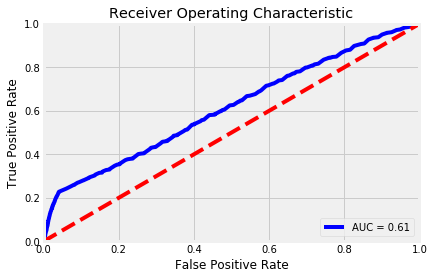

In [14]:
probs = rfe.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


We can see that our classifier is just above random chance. Hopefully we can improve this with some parameter tuning

In [15]:
# Tuning parameters for logistic regression
logit_params = {'C': [.01, .1, 1., 10., 100.], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
logit = LogisticRegression(class_weight='balanced')
lgt = GridSearchCV(logit, logit_params, cv=10)
lgt.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
# model accuracy
print('Acc: ', lgt.score(X_test, y_test))


print(lgt.best_params_)
C = lgt.best_params_['C']
solver = lgt.best_params_['solver']

Acc:  0.6299001446667373
{'C': 10.0, 'solver': 'newton-cg'}


In [35]:
logit = LogisticRegression(C=C, solver=solver)
logit = logit.fit(X_train, y_train)

pred = logit.predict(X_test)
train_score = logit.score(X_train, y_train)
test_score = logit.score(X_test, y_test)

print('train score: ', train_score)
print('test score: ', test_score)

0.6316643731696129


In [36]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[10988  3315]
 [ 7124  6914]]
              precision    recall  f1-score   support

           0       0.61      0.77      0.68     14303
           1       0.68      0.49      0.57     14038

   micro avg       0.63      0.63      0.63     28341
   macro avg       0.64      0.63      0.62     28341
weighted avg       0.64      0.63      0.62     28341



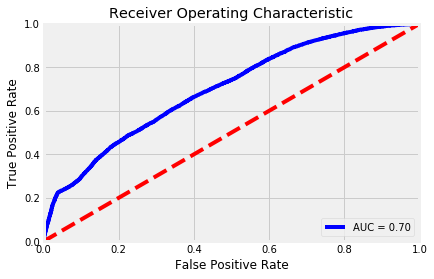

In [38]:
probs = logit.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Tuning the paramaters brought it up to a AUC score of .70.


## Random Forest Classifier
Our AUC score was pretty good, but I am interested in seeing the performance of the Random Forest Classifier to see if there are some undetected patterns that can be exposed in this classifier. 

In [82]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[NUMERIC], df[STATE], random_state=42)

In [83]:
rfc = RandomForestClassifier()
rfe = RFE(rfc)
rfe = rfe.fit(X_train, y_train)
#print(rfe.support_)
#print(rfe.ranking_)
support = np.array(rfe.support_)
ranking = np.array(rfe.ranking_)
# support
var_importance = pd.DataFrame({'support': support, 'ranking': ranking})
var_importance = var_importance.T
var_importance.columns = NUMERIC
var_importance

,main_category_encoded,sub_category_encoded,launched_at_month,deadline_month,goal,staff_pick
support,False,True,False,False,True,True
ranking,3,1,4,2,1,1


These results are suprising because it almost exactly the inverse of the importance fields for Logistic Regression. This classifiers leans more heavily on the opposite fields to determine the success of a paticular project.

In [84]:
rfc = RandomForestClassifier()
# Fit the pipeline to the training data

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
# Compute and print accuracy

train_score = rfc.score(X_train, y_train)
test_score = rfc.score(X_test, y_test)

print('train score: ', train_score)
print('test score: ', test_score)



#print("\RandomForestClassifier accuracy: ", accuracy)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train score:  0.8953212109806874
test score:  0.7103136798278114
[[10423  3880]
 [ 4330  9708]]
              precision    recall  f1-score   support

           0       0.71      0.73      0.72     14303
           1       0.71      0.69      0.70     14038

   micro avg       0.71      0.71      0.71     28341
   macro avg       0.71      0.71      0.71     28341
weighted avg       0.71      0.71      0.71     28341



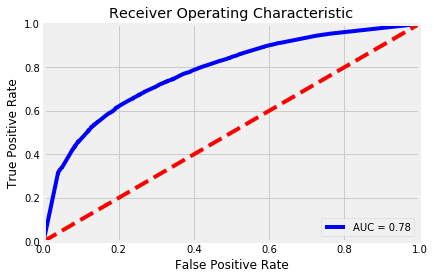

In [42]:
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



Out of the box, the AUC of the random forest is higher than the Logistic Regression classifier. However, looking at our model, we can see that the classifier could be overfitting with its built in parameters. Hopefully tuning will make it more accurate overall. 

In [43]:
# lets try tuning paramters!


In [86]:
X_train, X_test, y_train, y_test = train_test_split(df[NUMERIC], df[STATE], random_state=42)

In [89]:

parameters = {'n_estimators':list(range(2,7)),'min_samples_leaf': [10,50,100,200,500]}


rfc = RandomForestClassifier()
rfc = GridSearchCV(rfc, parameters, cv=5)
rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [2, 3, 4, 5, 6], 'min_samples_leaf': [10, 50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [90]:
# model accuracy
print('Acc: ', rfc.score(X_test, y_test))


print(rfc.best_params_)
n_estimators = rfc.best_params_['n_estimators']
min_samples_leaf = rfc.best_params_['min_samples_leaf']


Acc:  0.7385060513037649
{'min_samples_leaf': 50, 'n_estimators': 5}


In [91]:
rfc = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
rfc = rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
# Compute and print accuracy
train_score = rfc.score(X_train, y_train)
test_score = rfc.score(X_test, y_test)

print('train score: ', train_score)
print('test score: ', test_score)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train score:  0.7503352073580956
test score:  0.7373063759218094
[[11073  3230]
 [ 4215  9823]]
              precision    recall  f1-score   support

           0       0.72      0.77      0.75     14303
           1       0.75      0.70      0.73     14038

   micro avg       0.74      0.74      0.74     28341
   macro avg       0.74      0.74      0.74     28341
weighted avg       0.74      0.74      0.74     28341



By tuning these parameters, I was able to bring the test score up, and it is also significantly closer to the training accuracy score. This means that its not overfitting the data as much, making predictions potentially better.

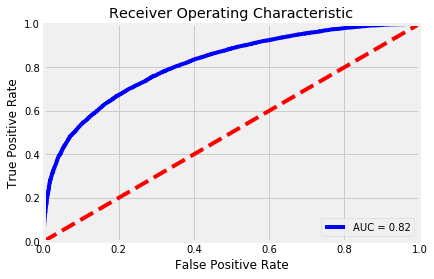

In [93]:
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

After parameter tuning we brought our AUC score up to 82, which is substantially better than the null AUC score of 50. Now I would like to turn my attention to the text data, to see if there are any bits of information that can be used in conjunction with my numberic modeling.

# Text Data
I will be using the description of the kickstarter project to see if there is useful attibutes in predicting success of a campaign. I will use a CountVectorizer, to create a way for classifiers to interpret the text data.

In [94]:
## play with NLP

In [95]:
def make_xy(df, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.blurb)
    y = df.state 
    return X, y
X, y = make_xy(df)

In [96]:
_, itest = train_test_split(range(df.shape[0]), train_size=0.7)
mask = np.zeros(df.shape[0], dtype=np.bool)
mask[itest] = True

In [101]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

#fit the model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

pred = mnb.predict(X_test)
# Compute and print accuracy

train_score = mnb.score(X_train, y_train)
test_score = mnb.score(X_test, y_test)

print('train score: ', train_score)
print('test score: ', test_score)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

train score:  0.7662877737732188
test score:  0.6692346143667852
[[11695  5469]
 [ 5780 11065]]
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     17164
           1       0.67      0.66      0.66     16845

   micro avg       0.67      0.67      0.67     34009
   macro avg       0.67      0.67      0.67     34009
weighted avg       0.67      0.67      0.67     34009



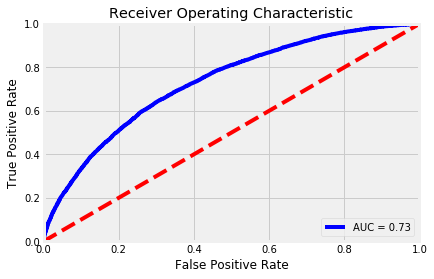

In [102]:
probs = mnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Out of the box we have a AUC score of .73 which is not bad! Our train and test data are a little far apart, so we should try to tune the parameters of the vectorizor and the classifier

In [111]:
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = None # 

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
best_ngram = None
ngram = [(1,2), (2, 3)]
min_dfs = [1,5,10,15]
for alpha in alphas:        
    for min_df in min_dfs:
        for gram in ngram:
            vectorizer = CountVectorizer(min_df= min_df, ngram_range=gram)       
            Xthis, ythis = make_xy(df, vectorizer)
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
            # your turn
            clf = MultinomialNB(alpha = alpha)
            clf.fit(X_train, y_train)
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            fpr, tpr, threshold = roc_curve(y_test, preds)
            roc_auc = auc(fpr, tpr)
    
            if roc_auc > maxscore:
                maxscore = roc_auc
                best_alpha, best_min_df, best_ngram = alpha, min_df, gram

In [112]:
print(best_alpha,best_ngram, best_min_df )

10 (1, 2) 15


Now that we have the best parameters, we will apply them to the classifier. 

In [115]:
vectorizer = CountVectorizer(min_df=best_min_df, ngram_range=best_ngram)
X, y = make_xy(df, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha)
clf.fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('train score: ', train_score)
print('test score: ', test_score)

Accuracy on training data: 0.727513
Accuracy on test data:     0.664226


Good words	     P(success | word)
   documentary about 0.89
            tabletop 0.88
         documentary 0.87
          board game 0.86
    documentary film 0.86
                dice 0.84
         roleplaying 0.83
  length documentary 0.82
          miniatures 0.80
             stretch 0.80
      is documentary 0.80
           residency 0.79
             heading 0.79
                 gbs 0.79
         gbs detroit 0.79
        record their 0.78
         for players 0.78
             chamber 0.78
           is making 0.78
 feature documentary 0.78
Bad words	     P(success | word)
             website 0.22
                 rap 0.22
             candles 0.22
                  im 0.22
            location 0.22
          food truck 0.21
            business 0.21
                 hip 0.21
             app for 0.21
            to start 0.21
             network 0.21
             hip hop 0.20
         application 0.20
               users 0.20
       clothing line 0.19
             apparel 0.

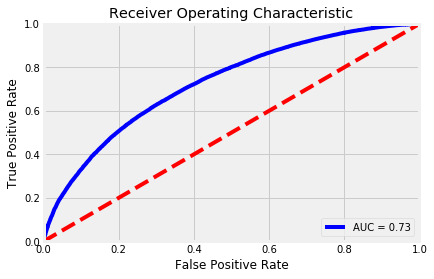

In [117]:
probs = clf.predict_proba(xtest)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

After tuning our parameters, we saw no improvement! Lets see if random forest can do a little better.

In [ ]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:20]]
bad_words = words[ind[-20:]]

good_prob = probs[ind[:20]]
bad_prob = probs[ind[-20:]]

print("Good words\t     P(success | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(success | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

These are the most common words and 2 word phrases associated with the successful and failed campaigns assiciate

In [ ]:
## lets try it with a randomforest

In [118]:
vectorizer = CountVectorizer(min_df=10, ngram_range=(1, 2))
X, y = make_xy(df, vectorizer)
X_train=X[mask]
y_train=y[mask]
X_test=X[~mask]
y_test=y[~mask]

clf = RandomForestClassifier().fit(X_train, y_train)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.981652
Accuracy on test data:     0.620838


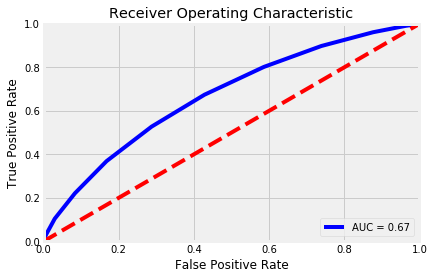

In [120]:
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Looks like this model significantly overfits, we will try to tune the parameters so its more accurate. 

In [121]:
clf = RandomForestClassifier()
parameters = { 'max_features':np.arange(5,10),'n_estimators':list(range(2,7)),'min_samples_leaf': [10,50,100,200,500]}

grid = GridSearchCV(clf, parameters, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': array([5, 6, 7, 8, 9]), 'n_estimators': [2, 3, 4, 5, 6], 'min_samples_leaf': [10, 50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [122]:
#grid.best_params_
max_features = grid.best_params_['max_features']
min_samples_leaf = grid.best_params_['min_samples_leaf']
n_estimators = grid.best_params_['n_estimators']

In [123]:
clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=max_features)
clf.fit(X_train, y_train)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.533124
Accuracy on test data:     0.531681


Looks like the parameter search significantly decreased overfitting, but now our accuracy is down to just above random chance.

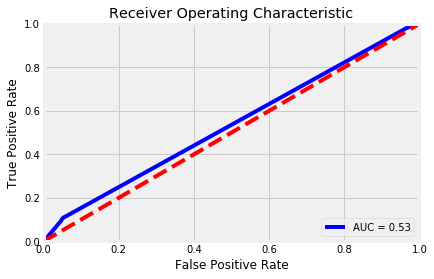

In [125]:
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The AUC score is far too low, so we will try to combine the efforts of the numberic classification with the 

In [129]:
# Obtain the text data: get_text_data
get_text_data = FunctionTransformer(lambda x: x['blurb'], validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC], validate=False)

X_train, X_test, y_train, y_test = train_test_split(df[['main_category_encoded',
                                                         'sub_category_encoded',
                                                         'launched_at_month',
                                                         'deadline_month',
                                                         'goal',
                                                         'staff_pick', 'blurb']],
                                                    df['state'], random_state=42)




In [147]:
# Obtain the text data: get_text_data
get_text_data = FunctionTransformer(lambda x: x['blurb'], validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC], validate=False)


X_train, X_test, y_train, y_test = train_test_split(df[['main_category_encoded',
                                                         'sub_category_encoded',
                                                         'launched_at_month',
                                                         'deadline_month',
                                                         'goal',
                                                         'staff_pick', 'blurb']],
                                                    df['state'], random_state=42)



pl_numeric = Pipeline([
                ('extract', get_numeric_data),
                ('rdm', RandomForestClassifier(min_samples_leaf=50, n_estimators=5))
])


pl_text = Pipeline([
                ('extract', get_text_data),
                ('vectorizer', CountVectorizer(min_df=best_min_df, ngram_range=best_ngram)),
                ('bayes', MultinomialNB(alpha=best_alpha))
])


vc = VotingClassifier(estimators=[ ('text', pl_text), ('numeric', pl_numeric)], voting='hard')


In [148]:
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('text', Pipeline(memory=None,
     steps=[('extract', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x120e6dea0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=False)), ('vectorize...=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [150]:
train_score = vc.score(X_train, y_train)
test_score = vc.score(X_test, y_test)

print('train score: ', train_score)
print('test score: ', test_score)

train score:  0.7196137470301804
test score:  0.6961292826646908


In [151]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[11139  3164]
 [ 5581  8457]]
              precision    recall  f1-score   support

           0       0.67      0.78      0.72     14303
           1       0.73      0.60      0.66     14038

   micro avg       0.69      0.69      0.69     28341
   macro avg       0.70      0.69      0.69     28341
weighted avg       0.70      0.69      0.69     28341



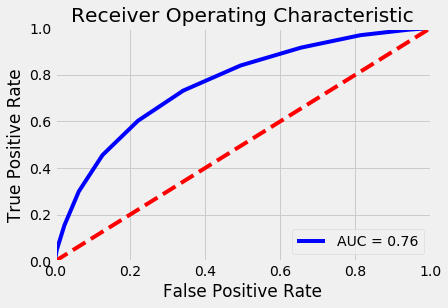

In [152]:
probs = pl.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion

Through creating these classifiers, we have achieved a combined score of .76. This is about 50 percent better than the null AUC score of .50. This is a pretty significant improvement from where we started, but generally still not super accurate. Since the features I was working with have no intrinsic measure about how good a paticular project will do in fundraising, the model had to generalize pretty significantly about the attributes. For a larger improvement, more features would be needed to make a better estimate. 